In [1]:
import numpy as np
import pandas as pd
import random
import os
# from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from federated_utils import *

In [2]:
#declear path to your data
derbin_data_path = '/home/gp/Desktop/ayushi-malware/federated-approach-malware/DW-FedAvg/drebin.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/federated-approach-malware/DW-FedAvg/malgenome.csv'
sample_data_path = '/home/gp/Desktop/ayushi-malware/federated-approach-malware/DW-FedAvg/Sample.csv'

In [3]:
derbin_data = pd.read_csv(derbin_data_path, header = None)
malgenome_data = pd.read_csv(malgenome_data_path)
sample_data = pd.read_csv(sample_data_path)

use_data  = sample_data

In [4]:
use_data

,"<actionandroid:name=""android.intent.action.FILEEXPLORE""/>\n","<actionandroid:name=""com.jb.gokeyboard.messagecenter.msgcontentactivity""/>\n","<actionandroid:name=""android.net.wifi.p2p.THIS_DEVICE_CHANGED""/>\n","<actionandroid:name=""com.citc.weather.widget.WIDGET_FORECAST_UPDATE""/>\n","<actionandroid:name=""com.meetup.action.GENERIC_SYNC""/>\n","<actionandroid:name=""br.com.mobicare.wifimanager.ACTION_WITHOUT_KNOW_NETWORKS""/>\n","<actionandroid:name=""com.krecorder.call.broadcast.UPLOAD_RETRY""/>\n","<actionandroid:name=""com.kreactive.digischool.bac.ACTION_UPDATE_CATEGORY_QUIZ_PROGRESS""/>\n","<actionandroid:name=""com.tpadsz.action.locker""/>\n","<actionandroid:name=""com.traceup.android.tracesnow.AddVisitComment.action.launch""/>\n",...,com.geoloqi.sample.permission.C2D_MESSAGE\n,com.tul.aviate.permission.C2D_MESSAGE\n,com.yandex.mail.permission.read_attachements\n,com.carfax.mycarfax.permission.C2D_MESSAGE\n,com.disney.frozensaga_goo.permission.C2D_MESSAGE\n,android.permission.FORCE_STOP_PACKAGES\n,com.copyop.android.app.permission.C2D_MESSAGE\n,com.sports.scores.baseball.schedule.toronto.blue_jays.permission.C2D_MESSAGE\n,com.flyersoft.moonreader.permission.C2D_MESSAGE\n,Binary_Type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S


In [5]:
X = np.array(use_data.iloc[:,range(0,8111)]) #feature set
labels = use_data.iloc[:,-1] #labels --> B : Benign and S

In [6]:
#binarize the labels
lb = LabelBinarizer()
y = lb.fit_transform(labels)

In [7]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=100)

In [8]:
number_of_clients = 5
comms_round = 10

In [9]:
#create clients -- Horizontal FL
clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [10]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
#==============================================
# Traditional FedAvg 2017
#==============================================
#-----------------------------------------------


all_results=list()

#create optimizer
lr = 0.01 
loss='binary_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X.shape[1],1)

global_DWFed_Avg_index = np.ones((1,number_of_clients))/number_of_clients # [0.3 0.3 0.3]

prev_local_model_test_performance = []

current_local_model_test_performance = []

beta= 0.2
#-----------------------------------------------


print('|=======================|')
print('|DWFedAvg FedAvg 2022   |')
print('|=======================|')

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X.shape[1],1)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #============================================================    
        # Custom Code added HERE for DWFedAvg
        #============================================================
        x_data = list()
        y_data = list()
        for local_i in clients_batched[client]:
            for local_j in local_i[0].numpy():
                x_data.append(local_j)
            for local_k in local_i[1].numpy():
                y_data.append(local_k[0])
                
        x_data = np.array(x_data) #x_TRAIN for corresponding client
        y_data = np.array(y_data) #y_TRAIN for corresponding client        
        
        #============================================================
        
        #fit local model with client's data
        history = local_model.fit(x_data,y_data, epochs=32, verbose=0, validation_split=0.2)
        
        current_local_model_test_performance.append(np.mean(history.history['val_accuracy'])) #saving local model test performmance
        
               
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
    
    
    
    if comm_round ==0:
        prev_local_model_test_performance = current_local_model_test_performance
        
    else:
        for jj in range(0,len(prev_local_model_test_performance)):
            
            #performance immproved
            if (current_local_model_test_performance[jj]>prev_local_model_test_performance[jj]):
                #print('YES')
                global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] + global_DWFed_Avg_index[jj]*beta
            
            #performance degraded
            elif (current_local_model_test_performance[jj]<prev_local_model_test_performance[jj]):
                #print('NO')
                global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] - global_DWFed_Avg_index[jj]*beta
                
           
                #print('NO CHANGE')
                
        global_DWFed_Avg_index = global_DWFed_Avg_index / sum(global_DWFed_Avg_index) #Weight scaling
        
    
#     print(global_DWFed_Avg_index)
        
        
    
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list, global_DWFed_Avg_index)
    #print(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss, global_f1, global_precision, global_recall, global_auc = test_model(X_test, Y_test, global_model, comm_round)
        all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc])
        

|=======================|
|DWFedAvg FedAvg 2022   |
|=======================|


/home/gp/anaconda3/envs/pySIO/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


comm_round: 0 | global_acc: 88.021% | global_loss: 0.6897585391998291 | global_f1: 0.7012987012987013 | global_precision: 0.9310344827586207 | global_recall: 0.5625 | global_auc: 0.9299768518518519 


/home/gp/anaconda3/envs/pySIO/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


comm_round: 1 | global_acc: 90.104% | global_loss: 0.6528205275535583 | global_f1: 0.7764705882352941 | global_precision: 0.8918918918918919 | global_recall: 0.6875 | global_auc: 0.9298321759259258 


/home/gp/anaconda3/envs/pySIO/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


comm_round: 2 | global_acc: 91.146% | global_loss: 0.6440889239311218 | global_f1: 0.8000000000000002 | global_precision: 0.918918918918919 | global_recall: 0.7083333333333334 | global_auc: 0.9348958333333333 


/home/gp/anaconda3/envs/pySIO/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


comm_round: 3 | global_acc: 92.188% | global_loss: 0.6429967284202576 | global_f1: 0.8275862068965517 | global_precision: 0.9230769230769231 | global_recall: 0.75 | global_auc: 0.931857638888889 


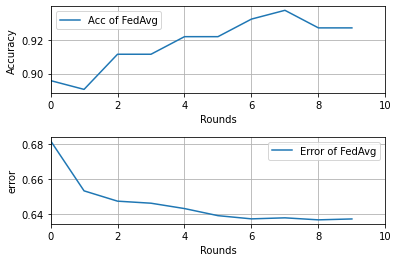

In [29]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()

